In [1]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
import statsmodels.api as sm
plt.style.use('fivethirtyeight')


from sklearn.preprocessing import RobustScaler, MinMaxScaler, MaxAbsScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.pipeline import make_pipeline

def find_outlier(x):
    q1 = x.describe()['25%']
    q3 = x.describe()['75%']
    iqr = abs(q1-q3)
    bttm_threshold = q1 - (iqr*1.5)
    top_threshold = q3 + (iqr*1.5)
    outlier = [i for i in x if i < bttm_threshold or i > top_threshold]
    outlier_array = np.array(outlier)
    return bttm_threshold, top_threshold, outlier_array


def pretty_print_linear(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name)
                                   for coef, name in lst)

# Preparing Dataset

In [14]:
df = pd.read_csv('AB_NYC_2019.csv')

In [15]:
df1 = df.copy()
df1['price'] = np.log1p(df1['price'])

# Removing Outlier with IQR
bttm_threshold, top_threshold, outlier_array = find_outlier(df1['price'])
bttm_threshold, top_threshold

df1 = df1[(df1['price'] >= bttm_threshold) & (df1['price'] <= top_threshold)] # 637 row deleted

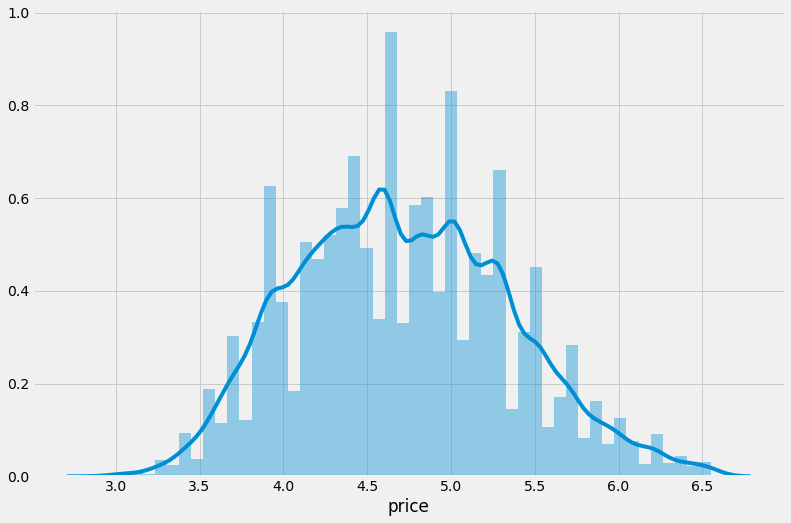

In [16]:
plt.figure(figsize=(12,8))
sns.distplot(df1['price']);

## Filling Null Value with 0

In [17]:
df1.fillna(0, inplace=True)
df1.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,5.010635,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,5.420535,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,5.017280,3,0,0,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,4.499810,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,4.394449,10,9,2018-11-19,0.10,1,0


## Dropping Unnecessary Columns

In [18]:
df_dropped = df1.copy()
df_dropped.drop(columns=['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'latitude', 'longitude', 'last_review'], inplace=True)
df_dropped.head()

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Private room,5.010635,1,9,0.21,6,365
1,Manhattan,Entire home/apt,5.420535,1,45,0.38,2,355
2,Manhattan,Private room,5.017280,3,0,0.00,1,365
3,Brooklyn,Entire home/apt,4.499810,1,270,4.64,1,194
4,Manhattan,Entire home/apt,4.394449,10,9,0.10,1,0


Dropping **`latitude`, `longitude`, `last_review`** karena kolom ini sudah diwakilkan dengan neighbourhood_group

## Encoding Categorical Column with LabelEncoder

In [19]:
df_dropped['neighbourhood_group'] = LabelEncoder().fit_transform(df_dropped['neighbourhood_group'])
df_dropped['room_type'] = LabelEncoder().fit_transform(df_dropped['room_type'])
df_dropped.head()

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,1,1,5.010635,1,9,0.21,6,365
1,2,0,5.420535,1,45,0.38,2,355
2,2,1,5.017280,3,0,0.00,1,365
3,1,0,4.499810,1,270,4.64,1,194
4,2,0,4.394449,10,9,0.10,1,0


## Splitting DataSet with Train_Test_Split

In [25]:
x = df_dropped.drop(columns='price')
y = df_dropped['price']

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [27]:
x_train = RobustScaler().fit_transform(x_train)
x_test = RobustScaler().fit_transform(x_test)

## 1.5 Modelling and Evaluating

In [31]:
linear = [LinearRegression(), Ridge()]
for i in linear:
    model = i
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'Model\t = {model}')
    print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}')
    print(f'MAE\t = {round(mean_absolute_error(y_test,y_pred), 2)}')
    print(f'R2 Score = {round( r2_score(y_test,y_pred) * 100 , 2)}')
    print('cross_val_score =', cross_val_score(model, x, y, scoring='r2',cv=5))
    print('cv mean =', cross_val_score(model, x, y, scoring='r2',cv=5).mean())
    print('cv std =', cross_val_score(model, x, y, scoring='r2',cv=5).std())
    print('\n')

Model	 = LinearRegression()
RMSE	 = 0.48
MAE	 = 0.37
R2 Score = 44.27
cross_val_score = [0.36183191 0.43263126 0.4065897  0.45092546 0.45385386]
cv mean = 0.4211664400601638
cv std = 0.0341132706490719


Model	 = Ridge()
RMSE	 = 0.48
MAE	 = 0.37
R2 Score = 44.27
cross_val_score = [0.36183832 0.4326341  0.4065915  0.45092353 0.45384569]
cv mean = 0.42116662801892524
cv std = 0.03410917523354923




## OLS

In [30]:
X_stat = df_dropped.drop(columns=['price']).values
y_stat = df_dropped['price'].values

X_stat = sm.add_constant(X_stat) # adding a constant

model = sm.OLS(y_stat, X_stat).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     5355.
Date:                Thu, 13 Aug 2020   Prob (F-statistic):               0.00
Time:                        12:37:36   Log-Likelihood:                -32966.
No. Observations:               48258   AIC:                         6.595e+04
Df Residuals:                   48250   BIC:                         6.602e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9808      0.006    814.796      0.0

---

# Try Using get_dummies

In [33]:
df1.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,5.010635,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,5.420535,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,5.017280,3,0,0,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,4.499810,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,4.394449,10,9,2018-11-19,0.10,1,0


In [34]:
df_dropped_enc = df1.copy()
df_dropped_enc.drop(columns=['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'latitude', 'longitude', 'last_review'], inplace=True)
df_dropped_enc.head()

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Private room,5.010635,1,9,0.21,6,365
1,Manhattan,Entire home/apt,5.420535,1,45,0.38,2,355
2,Manhattan,Private room,5.017280,3,0,0.00,1,365
3,Brooklyn,Entire home/apt,4.499810,1,270,4.64,1,194
4,Manhattan,Entire home/apt,4.394449,10,9,0.10,1,0


In [38]:
df_dropped_enc = pd.get_dummies(df_dropped_enc, prefix=['room_type'], columns=['room_type'])
df_dropped_enc = pd.get_dummies(df_dropped_enc, prefix=['neighbourhood_group'], columns=['neighbourhood_group'])

## Splitting Dataset with train_test_split

In [41]:
x1 = df_dropped_enc.drop(columns=['price'])
y1 = df_dropped_enc['price']

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2, random_state=42)

x1_train = RobustScaler().fit_transform(x1_train)
x1_test = RobustScaler().fit_transform(x1_test)

In [42]:
linear = [LinearRegression(), Ridge()]
for i in linear:
    model = i
    model.fit(x1_train, y1_train)
    y_pred = model.predict(x1_test)
    print(f'Model\t = {model}')
    print(f'RMSE\t = {round(np.sqrt(mean_squared_error(y1_test, y_pred)), 2)}')
    print(f'MAE\t = {round(mean_absolute_error(y1_test,y_pred), 2)}')
    print(f'R2 Score = {round( r2_score(y1_test,y_pred) * 100 , 2)}')
    print('cross_val_score =', cross_val_score(model, x1, y1, scoring='r2',cv=5))
    print('cv mean =', cross_val_score(model, x1, y1, scoring='r2',cv=5).mean())
    print('cv std =', cross_val_score(model, x1, y1, scoring='r2',cv=5).std())
    print('\n')

Model	 = LinearRegression()
RMSE	 = 0.44
MAE	 = 0.34
R2 Score = 51.87
cross_val_score = [0.42136121 0.49519358 0.4858748  0.53283171 0.55419734]
cv mean = 0.4978917301032036
cv std = 0.045606425144801385


Model	 = Ridge()
RMSE	 = 0.44
MAE	 = 0.34
R2 Score = 51.87
cross_val_score = [0.42137913 0.49521024 0.48587403 0.53282525 0.55417143]
cv mean = 0.49789201741680567
cv std = 0.04559286822542134




In [44]:
X1_stat = df_dropped_enc.drop(columns=['price']).values
y1_stat = df_dropped_enc['price'].values

X1_stat = sm.add_constant(X1_stat) # adding a constant

model = sm.OLS(y1_stat, X1_stat).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     4632.
Date:                Thu, 13 Aug 2020   Prob (F-statistic):               0.00
Time:                        12:49:41   Log-Likelihood:                -29446.
No. Observations:               48258   AIC:                         5.892e+04
Df Residuals:                   48246   BIC:                         5.902e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7695      0.005    569.911      0.0